In [1]:
# === Colab YOLOv8 training on your Drive dataset ===
# 1) Install deps (stable combo)
!pip install -U ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.8 MB/s eta 0:00:00


In [2]:

# 2) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# 3) Imports & paths
import os
from pathlib import Path
import yaml
import torch
from ultralytics import YOLO
from IPython.display import Image, display

# Your dataset lives here (exactly as you wrote):
DATASET_ROOT = Path("/content/drive/My Drive/Colab Notebooks/substation_elements_detection")
DATA_YAML_IN = DATASET_ROOT / "data.yaml"
TEST_IMAGE   = DATASET_ROOT / "test_image" / "test_image.jpg"

# Hyperparams (feel free to bump BATCH if GPU is strong)
BASE_WEIGHTS = "yolov8n.pt"   # 'yolov8s.pt' if you want stronger baseline
EPOCHS = 50
IMGSZ  = 640                  # You can keep 512 if you want it slightly lighter
BATCH  = 16                   # If you hit OOM, try 8 or 4
WORKERS = 2                   # Colab-safe
PLOTS   = True
PROJECT_DIR = DATASET_ROOT / "runs"   # all outputs here

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# 4) Normalize data.yaml to absolute Drive paths if needed
def normalize_data_yaml(yaml_path: Path, dataset_root: Path) -> Path:
    with open(yaml_path, "r", encoding="utf-8") as f:
        data_cfg = yaml.safe_load(f)

    expected_train = dataset_root / "train" / "images"
    expected_val   = dataset_root / "valid" / "images"
    expected_test  = dataset_root / "test"  / "images"

    def path_ok(pval):
        p = Path(pval)
        if not p.is_absolute():
            p = (dataset_root / p).resolve()
        return p.exists()

    # If any path is bad (e.g., Windows absolute or ../), rewrite as absolute
    if not path_ok(data_cfg.get("train", "")) or not path_ok(data_cfg.get("val", "")) or not path_ok(data_cfg.get("test", "")):
        data_cfg["path"]  = dataset_root.as_posix()
        data_cfg["train"] = expected_train.as_posix()
        data_cfg["val"]   = expected_val.as_posix()
        data_cfg["test"]  = expected_test.as_posix()

    out_path = dataset_root / "data_colab.yaml"
    with open(out_path, "w", encoding="utf-8") as f:
        yaml.safe_dump(data_cfg, f, sort_keys=False)
    return out_path

DATA_YAML_FIXED = normalize_data_yaml(DATA_YAML_IN, DATASET_ROOT)
print(f"[info] Using data file: {DATA_YAML_FIXED}")

# 5) Device: use GPU if available
device = 0 if torch.cuda.is_available() else "cpu"
print(f"[info] Device: {'GPU' if device==0 else 'CPU'} | Torch: {torch.__version__}")

[info] Using data file: /content/drive/My Drive/Colab Notebooks/substation_elements_detection/data_colab.yaml
[info] Device: GPU | Torch: 2.8.0+cu126


In [5]:

# 6) Train
model = YOLO(BASE_WEIGHTS)
train_results = model.train(
    data=str(DATA_YAML_FIXED),
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    device=device,
    project=str(PROJECT_DIR),
    name="yolov8_train",
    exist_ok=True,
    workers=WORKERS,
    plots=PLOTS,
    cache=True     # OK on Colab; speeds up after first epoch
)
best_pt = PROJECT_DIR / "yolov8_train" / "weights" / "best.pt"
print("[info] Training complete. Best weights at:", best_pt.as_posix())

Ultralytics 8.3.194 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/Colab Notebooks/substation_elements_detection/data_colab.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patie

In [6]:
# 7) Evaluate on TEST split
val_metrics = model.val(
    data=str(DATA_YAML_FIXED),
    split="test",
    imgsz=IMGSZ,
    device=device,
    workers=WORKERS,
    plots=PLOTS,
    save_json=False
)
print("[info] Test metrics:", getattr(val_metrics, "results_dict", val_metrics))

Ultralytics 8.3.194 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,008,378 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 4.9±9.0 ms, read: 2.1±4.3 MB/s, size: 59.2 KB)
val: Scanning /content/drive/My Drive/Colab Notebooks/substation_elements_detection/test/labels... 166 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 166/166 2.7it/s 1:02
val: New cache created: /content/drive/My Drive/Colab Notebooks/substation_elements_detection/test/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.
val: Caching images (0.2GB RAM): 100% ━━━━━━━━━━━━ 166/166 183.4it/s 0.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 2.0it/s 5.5s
                   all        166       4921      0.777      0.585      0.646      0.333
                     B       

In [7]:
# 8) Single-image inference
infer_model = YOLO(best_pt.as_posix() if best_pt.exists() else BASE_WEIGHTS)
pred = infer_model.predict(
    source=TEST_IMAGE.as_posix(),
    imgsz=IMGSZ,
    conf=0.25,
    save=True,
    project=str(PROJECT_DIR),
    name="predict_one",
    exist_ok=True,
    device=device,
    workers=WORKERS,
    stream=False,
    verbose=True
)
pred_dir = PROJECT_DIR / "predict_one"
print("[info] Prediction saved under", pred_dir.as_posix())


image 1/1 /content/drive/My Drive/Colab Notebooks/substation_elements_detection/test_image/test_image.jpg: 640x640 1 B, 1 CBDS, 4 FSWs, 1 OPDS, 1 POW_T, 25 PPIs, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/My Drive/Colab Notebooks/substation_elements_detection/runs/predict_one
[info] Prediction saved under /content/drive/My Drive/Colab Notebooks/substation_elements_detection/runs/predict_one


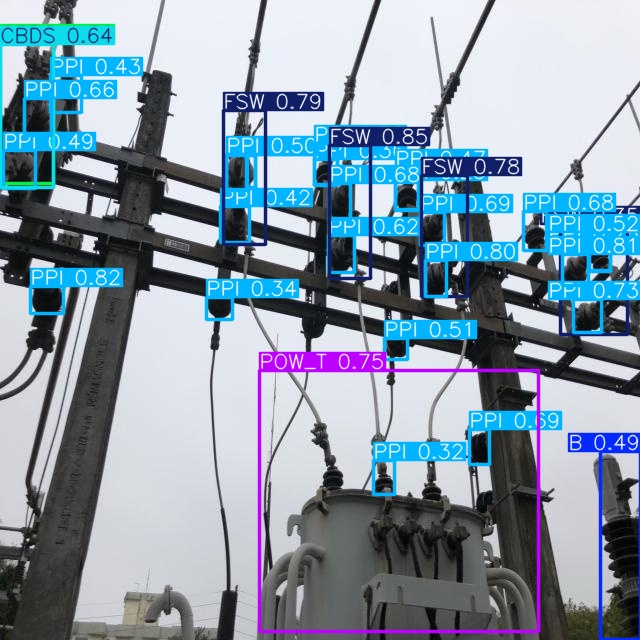

Predicted class name map: {0: 'B', 1: 'CBDS', 2: 'CT', 3: 'CTDS', 4: 'FSW', 5: 'GDI', 6: 'LA', 7: 'M', 8: 'OPDS', 9: 'POW_T', 10: 'PPI', 11: 'PT', 12: 'R', 13: 'TDS'}


In [8]:
# 9) Display the saved prediction (first image)
# The saved image filename mirrors your source name; we just show the first file we find.
try:
    saved_imgs = sorted(list(pred_dir.glob("*.jpg")) + list(pred_dir.glob("*.png")))
    if saved_imgs:
        display(Image(filename=saved_imgs[0].as_posix()))
    else:
        print("[warn] No saved images found in predict_one.")
except Exception as e:
    print("[warn] Could not display image:", e)

# Optional: print class name mapping
if len(pred) > 0:
    print("Predicted class name map:", pred[0].names)